In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=2

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",
                                     with_l2=True,with_l3=True,with_l4=True,with_l5=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    ,
                    'l4_3006_xgb_fold{}_False_d478.pkl', 'l4_3000_ridge_fold{}_False_d478.pkl', 'l4_3001_lgb_fold{}_False_d478.pkl', 'l4_3003_conv_fold{}_False_d478.pkl'                    
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1571
0
(201158, 1, 40) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 264) (201158,) (201158,)
(49582, 1, 40) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 264) (49582,) (49582,)
(5803, 1, 40) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 264) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40127	valid-rmse:2.36329
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.984943	valid-rmse:0.973788
[100]	train-rmse:0.572822	valid-rmse:0.578732
[150]	train-rmse:0.488736	valid-rmse:0.504283
[200]	train-rmse:0.47283	valid-rmse:0.493833
[250]	train-rmse:0.467381	valid-rmse:0.492651
[300]	train-rmse:0.463849	valid-rmse:0.492578
Stopping. Best iteration:
[270]	train-rmse:0.465796	valid-rmse:0.492545

0.21696633 0.24260066
[0.24260066]
-1 mean score 0.24260066
0.193601205945


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919019  0.010091  0.204544    7  2017-04-16
472     2.507290  2.525563 -0.018272  0.209625    1  2017-04-17
473     2.661330  2.658691  0.002639  0.222946    2  2017-04-18
474     2.754815  2.738755  0.016060  0.189997    3  2017-04-19
475     2.713762  2.705887  0.007874  0.211958    4  2017-04-20
476     2.999000  2.977188  0.021811  0.144526    5  2017-04-21
477     3.075529  3.068761  0.006769  0.171613    6  2017-04-22

0.193601205945


pred         y     error    error2  day        date
dayidx                                                         
471     2.919019  2.929110  0.010091  0.204544    7  2017-04-16
472     2.525563  2.507290 -0.018272  0.209625    1  2017-04-17
473     2.658691  2.661330  0.002639  0.222946    2  2017-04-18
474     2.738755  2.754815  0.016060  0.189997    3  2017-04-19
475     2.705887  2.713762  0.007874  0.211958    4  2017-04-20
476     2.977188  2.999000  0.021811  0.144526    5  2017-04-21
477     3.068761  3.075529  0.006769  0.171613    6  2017-04-22

(829, 264)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200932, 2) (49525, 2)
train/valid # (200932, 2) (49525, 2)
rand split across time
train has 200932 records out of 389630 records
valid has 49525 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1569
0
(200932, 1, 40) (200932, 7, 32) (200932, 1) (200932, 1)
(200932, 264) (200932,) (200932,)
(49525, 1, 40) (49525, 7, 32) (49525, 1) (49525, 1)
(49525, 264) (49525,) (49525,)
(6632, 1, 40) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 264) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40108	valid-rmse:2.36304
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.98692	valid-rmse:0.976689
[100]	train-rmse:0.576171	valid-rmse:0.584202
[150]	train-rmse:0.491784	valid-rmse:0.510585
[200]	train-rmse:0.475495	valid-rmse:0.500149
[250]	train-rmse:0.46973	valid-rmse:0.498828
[300]	train-rmse:0.465853	valid-rmse:0.498672
[350]	train-rmse:0.463223	valid-rmse:0.498665
Stopping. Best iteration:
[313]	train-rmse:0.465164	valid-rmse:0.498655

0.21637797 0.24865687
[0.24865687]
-1 mean score 0.24865687
0.191366717219


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910960  0.018150  0.201670    7  2017-04-16
472     2.507290  2.527408 -0.020118  0.206567    1  2017-04-17
473     2.661330  2.660295  0.001035  0.217439    2  2017-04-18
474     2.754815  2.748658  0.006156  0.189674    3  2017-04-19
475     2.713762  2.715130 -0.001368  0.212391    4  2017-04-20
476     2.999000  2.982407  0.016592  0.145528    5  2017-04-21
477     3.075529  3.066253  0.009277  0.166299    6  2017-04-22

0.191366717219


pred         y     error    error2  day        date
dayidx                                                         
471     2.910960  2.929110  0.018150  0.201670    7  2017-04-16
472     2.527408  2.507290 -0.020118  0.206567    1  2017-04-17
473     2.660295  2.661330  0.001035  0.217439    2  2017-04-18
474     2.748658  2.754815  0.006156  0.189674    3  2017-04-19
475     2.715130  2.713762 -0.001368  0.212391    4  2017-04-20
476     2.982407  2.999000  0.016592  0.145528    5  2017-04-21
477     3.066253  3.075529  0.009277  0.166299    6  2017-04-22

(829, 264)


3
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200747, 2) (49483, 2)
train/valid # (200747, 2) (49483, 2)
rand split across time
train has 200747 records out of 389630 records
valid has 49483 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1568
0
(200747, 1, 40) (200747, 7, 32) (200747, 1) (200747, 1)
(200747, 264) (200747,) (200747,)
(49483, 1, 40) (49483, 7, 32) (49483, 1) (49483, 1)
(49483, 264) (49483,) (49483,)
(7461, 1, 40) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 264) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40086	valid-rmse:2.36278
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987799	valid-rmse:0.975852
[100]	train-rmse:0.578236	valid-rmse:0.584386
[150]	train-rmse:0.494233	valid-rmse:0.511546
[200]	train-rmse:0.477982	valid-rmse:0.501489
[250]	train-rmse:0.471934	valid-rmse:0.500288
[300]	train-rmse:0.467987	valid-rmse:0.500202
[350]	train-rmse:0.464726	valid-rmse:0.500202
Stopping. Best iteration:
[348]	train-rmse:0.464852	valid-rmse:0.500184

0.21608739 0.25018454
[0.25018454]
-1 mean score 0.25018454
0.195094585419


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903507  0.025603  0.205396    7  2017-04-16
472     2.507290  2.519085 -0.011794  0.209903    1  2017-04-17
473     2.661330  2.650957  0.010373  0.228114    2  2017-04-18
474     2.754815  2.766001 -0.011186  0.191947    3  2017-04-19
475     2.713762  2.716834 -0.003073  0.211141    4  2017-04-20
476     2.999000  2.982572  0.016428  0.146322    5  2017-04-21
477     3.075529  3.062196  0.013333  0.172839    6  2017-04-22

0.195094585419


pred         y     error    error2  day        date
dayidx                                                         
471     2.903507  2.929110  0.025603  0.205396    7  2017-04-16
472     2.519085  2.507290 -0.011794  0.209903    1  2017-04-17
473     2.650957  2.661330  0.010373  0.228114    2  2017-04-18
474     2.766001  2.754815 -0.011186  0.191947    3  2017-04-19
475     2.716834  2.713762 -0.003073  0.211141    4  2017-04-20
476     2.982572  2.999000  0.016428  0.146322    5  2017-04-21
477     3.062196  3.075529  0.013333  0.172839    6  2017-04-22

(829, 264)


4
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200584, 2) (49444, 2)
train/valid # (200584, 2) (49444, 2)
rand split across time
train has 200584 records out of 389630 records
valid has 49444 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1567
0
(200584, 1, 40) (200584, 7, 32) (200584, 1) (200584, 1)
(200584, 264) (200584,) (200584,)
(49444, 1, 40) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 264) (49444,) (49444,)
(8290, 1, 40) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 264) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40086	valid-rmse:2.36287
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988439	valid-rmse:0.980917
[100]	train-rmse:0.579299	valid-rmse:0.58975
[150]	train-rmse:0.495582	valid-rmse:0.515164
[200]	train-rmse:0.479464	valid-rmse:0.504159
[250]	train-rmse:0.473737	valid-rmse:0.502564
[300]	train-rmse:0.469856	valid-rmse:0.502243
[350]	train-rmse:0.466924	valid-rmse:0.502195
[400]	train-rmse:0.46421	valid-rmse:0.502207
Stopping. Best iteration:
[361]	train-rmse:0.466317	valid-rmse:0.502174

0.21745187 0.2521791
[0.2521791]
-1 mean score 0.2521791
0.194953173399


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905709  0.023401  0.210691    7  2017-04-16
472     2.507290  2.511248 -0.003958  0.208452    1  2017-04-17
473     2.661330  2.627759  0.033571  0.222861    2  2017-04-18
474     2.754815  2.741586  0.013229  0.195047    3  2017-04-19
475     2.713762  2.715472 -0.001710  0.209931    4  2017-04-20
476     2.999000  2.964489  0.034511  0.147366    5  2017-04-21
477     3.075529  3.054976  0.020554  0.170324    6  2017-04-22

0.194953173399


pred         y     error    error2  day        date
dayidx                                                         
471     2.905709  2.929110  0.023401  0.210691    7  2017-04-16
472     2.511248  2.507290 -0.003958  0.208452    1  2017-04-17
473     2.627759  2.661330  0.033571  0.222861    2  2017-04-18
474     2.741586  2.754815  0.013229  0.195047    3  2017-04-19
475     2.715472  2.713762 -0.001710  0.209931    4  2017-04-20
476     2.964489  2.999000  0.034511  0.147366    5  2017-04-21
477     3.054976  3.075529  0.020554  0.170324    6  2017-04-22

(829, 264)


5
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200384, 2) (49392, 2)
train/valid # (200384, 2) (49392, 2)
rand split across time
train has 200384 records out of 389630 records
valid has 49392 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1565
0
(200384, 1, 40) (200384, 7, 32) (200384, 1) (200384, 1)
(200384, 264) (200384,) (200384,)
(49392, 1, 40) (49392, 7, 32) (49392, 1) (49392, 1)
(49392, 264) (49392,) (49392,)
(9119, 1, 40) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 264) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40111	valid-rmse:2.36293
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989131	valid-rmse:0.978051
[100]	train-rmse:0.580256	valid-rmse:0.588155
[150]	train-rmse:0.49651	valid-rmse:0.515594
[200]	train-rmse:0.480352	valid-rmse:0.505573
[250]	train-rmse:0.474683	valid-rmse:0.504358
[300]	train-rmse:0.470712	valid-rmse:0.504243
[350]	train-rmse:0.467867	valid-rmse:0.50423
Stopping. Best iteration:
[313]	train-rmse:0.469838	valid-rmse:0.504202

0.22074795 0.25422013
[0.25422013]
-1 mean score 0.25422013
0.199013695121


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905996  0.023114  0.214487    7  2017-04-16
472     2.507290  2.521899 -0.014608  0.216890    1  2017-04-17
473     2.661330  2.625629  0.035701  0.228696    2  2017-04-18
474     2.754815  2.729109  0.025706  0.193745    3  2017-04-19
475     2.713762  2.703219  0.010543  0.216763    4  2017-04-20
476     2.999000  2.964762  0.034237  0.153311    5  2017-04-21
477     3.075529  3.052250  0.023279  0.169205    6  2017-04-22

0.199013695121


pred         y     error    error2  day        date
dayidx                                                         
471     2.905996  2.929110  0.023114  0.214487    7  2017-04-16
472     2.521899  2.507290 -0.014608  0.216890    1  2017-04-17
473     2.625629  2.661330  0.035701  0.228696    2  2017-04-18
474     2.729109  2.754815  0.025706  0.193745    3  2017-04-19
475     2.703219  2.713762  0.010543  0.216763    4  2017-04-20
476     2.964762  2.999000  0.034237  0.153311    5  2017-04-21
477     3.052250  3.075529  0.023279  0.169205    6  2017-04-22

(829, 264)


6
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 15.133374
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200174, 2) (49339, 2)
train/valid # (200174, 2) (49339, 2)
rand split across time
train has 200174 records out of 389630 records
valid has 49339 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1563
0
(200174, 1, 40) (200174, 7, 32) (200174, 1) (200174, 1)
(200174, 264) (200174,) (200174,)
(49339, 1, 40) (49339, 7, 32) (49339, 1) (49339, 1)
(49339, 264) (49339,) (49339,)
(9948, 1, 40) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 264) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4013	valid-rmse:2.36315
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989752	valid-rmse:0.984052
[100]	train-rmse:0.581536	valid-rmse:0.593288
[150]	train-rmse:0.498093	valid-rmse:0.518266
[200]	train-rmse:0.481874	valid-rmse:0.506947
[250]	train-rmse:0.476176	valid-rmse:0.505235
[300]	train-rmse:0.472594	valid-rmse:0.504913
[350]	train-rmse:0.470532	valid-rmse:0.504888
Stopping. Best iteration:
[336]	train-rmse:0.471251	valid-rmse:0.504881

0.22207741 0.2549052
[0.2549052]
-1 mean score 0.2549052
0.201907977462


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912726  0.016384  0.217167    7  2017-04-16
472     2.507290  2.527721 -0.020430  0.224187    1  2017-04-17
473     2.661330  2.629847  0.031483  0.230909    2  2017-04-18
474     2.754815  2.732536  0.022279  0.196253    3  2017-04-19
475     2.713762  2.716674 -0.002912  0.221778    4  2017-04-20
476     2.999000  2.951697  0.047303  0.151259    5  2017-04-21
477     3.075529  3.064922  0.010607  0.171802    6  2017-04-22

0.201907977462


pred         y     error    error2  day        date
dayidx                                                         
471     2.912726  2.929110  0.016384  0.217167    7  2017-04-16
472     2.527721  2.507290 -0.020430  0.224187    1  2017-04-17
473     2.629847  2.661330  0.031483  0.230909    2  2017-04-18
474     2.732536  2.754815  0.022279  0.196253    3  2017-04-19
475     2.716674  2.713762 -0.002912  0.221778    4  2017-04-20
476     2.951697  2.999000  0.047303  0.151259    5  2017-04-21
477     3.064922  3.075529  0.010607  0.171802    6  2017-04-22

(829, 264)


7
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 16.310143
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199954, 2) (49285, 2)
train/valid # (199954, 2) (49285, 2)
rand split across time
train has 199954 records out of 389630 records
valid has 49285 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1562
0
(199954, 1, 40) (199954, 7, 32) (199954, 1) (199954, 1)
(199954, 264) (199954,) (199954,)
(49285, 1, 40) (49285, 7, 32) (49285, 1) (49285, 1)
(49285, 264) (49285,) (49285,)
(10777, 1, 40) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 264) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40146	valid-rmse:2.36313
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990783	valid-rmse:0.98296
[100]	train-rmse:0.583315	valid-rmse:0.593793
[150]	train-rmse:0.500141	valid-rmse:0.520244
[200]	train-rmse:0.484276	valid-rmse:0.509522
[250]	train-rmse:0.478815	valid-rmse:0.508014
[300]	train-rmse:0.474752	valid-rmse:0.507821
Stopping. Best iteration:
[298]	train-rmse:0.47484	valid-rmse:0.507815

0.22547255 0.2578762
[0.2578762]
-1 mean score 0.2578762
0.203074619174


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908572  0.020538  0.219117    7  2017-04-16
472     2.507290  2.537030 -0.029740  0.223979    1  2017-04-17
473     2.661330  2.632224  0.029105  0.234518    2  2017-04-18
474     2.754815  2.723003  0.031812  0.197140    3  2017-04-19
475     2.713762  2.704671  0.009091  0.221250    4  2017-04-20
476     2.999000  2.967499  0.031501  0.151176    5  2017-04-21
477     3.075529  3.079597 -0.004067  0.174341    6  2017-04-22

0.203074619174


pred         y     error    error2  day        date
dayidx                                                         
471     2.908572  2.929110  0.020538  0.219117    7  2017-04-16
472     2.537030  2.507290 -0.029740  0.223979    1  2017-04-17
473     2.632224  2.661330  0.029105  0.234518    2  2017-04-18
474     2.723003  2.754815  0.031812  0.197140    3  2017-04-19
475     2.704671  2.713762  0.009091  0.221250    4  2017-04-20
476     2.967499  2.999000  0.031501  0.151176    5  2017-04-21
477     3.079597  3.075529 -0.004067  0.174341    6  2017-04-22

(829, 264)


8
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 17.574337
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199722, 2) (49227, 2)
train/valid # (199722, 2) (49227, 2)
rand split across time
train has 199722 records out of 389630 records
valid has 49227 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1560
0
(199722, 1, 40) (199722, 7, 32) (199722, 1) (199722, 1)
(199722, 264) (199722,) (199722,)
(49227, 1, 40) (49227, 7, 32) (49227, 1) (49227, 1)
(49227, 264) (49227,) (49227,)
(11606, 1, 40) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 264) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40139	valid-rmse:2.36275
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992333	valid-rmse:0.981856
[100]	train-rmse:0.586064	valid-rmse:0.594723
[150]	train-rmse:0.503386	valid-rmse:0.523036
[200]	train-rmse:0.487217	valid-rmse:0.512943
[250]	train-rmse:0.481677	valid-rmse:0.51169
[300]	train-rmse:0.477654	valid-rmse:0.511593
Stopping. Best iteration:
[275]	train-rmse:0.479592	valid-rmse:0.511551

0.23000813 0.2616846
[0.2616846]
-1 mean score 0.2616846
0.20876480639


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918141  0.010969  0.228466    7  2017-04-16
472     2.507290  2.539089 -0.031799  0.222108    1  2017-04-17
473     2.661330  2.641999  0.019330  0.242899    2  2017-04-18
474     2.754815  2.726560  0.028255  0.206665    3  2017-04-19
475     2.713762  2.705734  0.008028  0.227004    4  2017-04-20
476     2.999000  2.953831  0.045169  0.158715    5  2017-04-21
477     3.075529  3.079638 -0.004109  0.175497    6  2017-04-22

0.20876480639


pred         y     error    error2  day        date
dayidx                                                         
471     2.918141  2.929110  0.010969  0.228466    7  2017-04-16
472     2.539089  2.507290 -0.031799  0.222108    1  2017-04-17
473     2.641999  2.661330  0.019330  0.242899    2  2017-04-18
474     2.726560  2.754815  0.028255  0.206665    3  2017-04-19
475     2.705734  2.713762  0.008028  0.227004    4  2017-04-20
476     2.953831  2.999000  0.045169  0.158715    5  2017-04-21
477     3.079638  3.075529 -0.004109  0.175497    6  2017-04-22

(829, 264)


9
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 18.806503
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199495, 2) (49172, 2)
train/valid # (199495, 2) (49172, 2)
rand split across time
train has 199495 records out of 389630 records
valid has 49172 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1558
0
(199495, 1, 40) (199495, 7, 32) (199495, 1) (199495, 1)
(199495, 264) (199495,) (199495,)
(49172, 1, 40) (49172, 7, 32) (49172, 1) (49172, 1)
(49172, 264) (49172,) (49172,)
(12435, 1, 40) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 264) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40111	valid-rmse:2.36242
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993207	valid-rmse:0.982769
[100]	train-rmse:0.588065	valid-rmse:0.596306
[150]	train-rmse:0.505508	valid-rmse:0.524616
[200]	train-rmse:0.489232	valid-rmse:0.514508
[250]	train-rmse:0.483152	valid-rmse:0.513207
[300]	train-rmse:0.478984	valid-rmse:0.513094
Stopping. Best iteration:
[288]	train-rmse:0.479865	valid-rmse:0.513053

0.23027067 0.2632229
[0.2632229]
-1 mean score 0.2632229
0.208941563964


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912156  0.016953  0.230396    7  2017-04-16
472     2.507290  2.543208 -0.035917  0.223209    1  2017-04-17
473     2.661330  2.664945 -0.003616  0.244633    2  2017-04-18
474     2.754815  2.726868  0.027947  0.206426    3  2017-04-19
475     2.713762  2.705831  0.007931  0.224050    4  2017-04-20
476     2.999000  2.958197  0.040803  0.158132    5  2017-04-21
477     3.075529  3.072196  0.003333  0.175745    6  2017-04-22

0.208941563964


pred         y     error    error2  day        date
dayidx                                                         
471     2.912156  2.929110  0.016953  0.230396    7  2017-04-16
472     2.543208  2.507290 -0.035917  0.223209    1  2017-04-17
473     2.664945  2.661330 -0.003616  0.244633    2  2017-04-18
474     2.726868  2.754815  0.027947  0.206426    3  2017-04-19
475     2.705831  2.713762  0.007931  0.224050    4  2017-04-20
476     2.958197  2.999000  0.040803  0.158132    5  2017-04-21
477     3.072196  3.075529  0.003333  0.175745    6  2017-04-22

(829, 264)


10
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 19.926521
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199316, 2) (49135, 2)
train/valid # (199316, 2) (49135, 2)
rand split across time
train has 199316 records out of 389630 records
valid has 49135 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1557
0
(199316, 1, 40) (199316, 7, 32) (199316, 1) (199316, 1)
(199316, 264) (199316,) (199316,)
(49135, 1, 40) (49135, 7, 32) (49135, 1) (49135, 1)
(49135, 264) (49135,) (49135,)
(13264, 1, 40) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 264) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4011	valid-rmse:2.36225
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99354	valid-rmse:0.980026
[100]	train-rmse:0.588581	valid-rmse:0.594196
[150]	train-rmse:0.506098	valid-rmse:0.523871
[200]	train-rmse:0.48984	valid-rmse:0.51456
[250]	train-rmse:0.484121	valid-rmse:0.513548
[300]	train-rmse:0.47991	valid-rmse:0.513581
Stopping. Best iteration:
[277]	train-rmse:0.481762	valid-rmse:0.513522

0.23209447 0.2637045
[0.2637045]
-1 mean score 0.2637045
0.209228187799


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910768  0.018342  0.225818    7  2017-04-16
472     2.507290  2.529819 -0.022528  0.220441    1  2017-04-17
473     2.661330  2.665317 -0.003988  0.249734    2  2017-04-18
474     2.754815  2.739149  0.015666  0.205366    3  2017-04-19
475     2.713762  2.713982 -0.000221  0.227463    4  2017-04-20
476     2.999000  2.961796  0.037203  0.160219    5  2017-04-21
477     3.075529  3.077909 -0.002380  0.175557    6  2017-04-22

0.209228187799


pred         y     error    error2  day        date
dayidx                                                         
471     2.910768  2.929110  0.018342  0.225818    7  2017-04-16
472     2.529819  2.507290 -0.022528  0.220441    1  2017-04-17
473     2.665317  2.661330 -0.003988  0.249734    2  2017-04-18
474     2.739149  2.754815  0.015666  0.205366    3  2017-04-19
475     2.713982  2.713762 -0.000221  0.227463    4  2017-04-20
476     2.961796  2.999000  0.037203  0.160219    5  2017-04-21
477     3.077909  3.075529 -0.002380  0.175557    6  2017-04-22

(829, 264)


11
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 21.05768
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199138, 2) (49087, 2)
train/valid # (199138, 2) (49087, 2)
rand split across time
train has 199138 records out of 389630 records
valid has 49087 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1555
0
(199138, 1, 40) (199138, 7, 32) (199138, 1) (199138, 1)
(199138, 264) (199138,) (199138,)
(49087, 1, 40) (49087, 7, 32) (49087, 1) (49087, 1)
(49087, 264) (49087,) (49087,)
(14093, 1, 40) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 264) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4014	valid-rmse:2.36262
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993924	valid-rmse:0.984082
[100]	train-rmse:0.589069	valid-rmse:0.597696
[150]	train-rmse:0.506406	valid-rmse:0.525586
[200]	train-rmse:0.490449	valid-rmse:0.515435
[250]	train-rmse:0.48458	valid-rmse:0.514039
[300]	train-rmse:0.480308	valid-rmse:0.513899
Stopping. Best iteration:
[287]	train-rmse:0.481342	valid-rmse:0.513861

0.2316906 0.2640534
[0.2640534]
-1 mean score 0.2640534
0.208600267768


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901590  0.027520  0.226191    7  2017-04-16
472     2.507290  2.529666 -0.022375  0.219198    1  2017-04-17
473     2.661330  2.657996  0.003334  0.251059    2  2017-04-18
474     2.754815  2.724846  0.029969  0.207270    3  2017-04-19
475     2.713762  2.723407 -0.009645  0.222844    4  2017-04-20
476     2.999000  2.968131  0.030869  0.159232    5  2017-04-21
477     3.075529  3.062054  0.013475  0.174408    6  2017-04-22

0.208600267768


pred         y     error    error2  day        date
dayidx                                                         
471     2.901590  2.929110  0.027520  0.226191    7  2017-04-16
472     2.529666  2.507290 -0.022375  0.219198    1  2017-04-17
473     2.657996  2.661330  0.003334  0.251059    2  2017-04-18
474     2.724846  2.754815  0.029969  0.207270    3  2017-04-19
475     2.723407  2.713762 -0.009645  0.222844    4  2017-04-20
476     2.968131  2.999000  0.030869  0.159232    5  2017-04-21
477     3.062054  3.075529  0.013475  0.174408    6  2017-04-22

(829, 264)


12
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 22.115147
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198922, 2) (49036, 2)
train/valid # (198922, 2) (49036, 2)
rand split across time
train has 198922 records out of 389630 records
valid has 49036 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1554
0
(198922, 1, 40) (198922, 7, 32) (198922, 1) (198922, 1)
(198922, 264) (198922,) (198922,)
(49036, 1, 40) (49036, 7, 32) (49036, 1) (49036, 1)
(49036, 264) (49036,) (49036,)
(14922, 1, 40) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 264) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40164	valid-rmse:2.3626
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994696	valid-rmse:0.983116
[100]	train-rmse:0.590435	valid-rmse:0.597848
[150]	train-rmse:0.508212	valid-rmse:0.526797
[200]	train-rmse:0.492133	valid-rmse:0.516916
[250]	train-rmse:0.4863	valid-rmse:0.515711
[300]	train-rmse:0.482478	valid-rmse:0.515623
Stopping. Best iteration:
[272]	train-rmse:0.484478	valid-rmse:0.515587

0.23471929 0.2658301
[0.2658301]
-1 mean score 0.2658301
0.210470870137


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891975  0.037134  0.230776    7  2017-04-16
472     2.507290  2.537484 -0.030194  0.217618    1  2017-04-17
473     2.661330  2.660173  0.001157  0.253162    2  2017-04-18
474     2.754815  2.719038  0.035777  0.208647    3  2017-04-19
475     2.713762  2.721495 -0.007734  0.223931    4  2017-04-20
476     2.999000  2.964294  0.034706  0.164702    5  2017-04-21
477     3.075529  3.064062  0.011467  0.174459    6  2017-04-22

0.210470870137


pred         y     error    error2  day        date
dayidx                                                         
471     2.891975  2.929110  0.037134  0.230776    7  2017-04-16
472     2.537484  2.507290 -0.030194  0.217618    1  2017-04-17
473     2.660173  2.661330  0.001157  0.253162    2  2017-04-18
474     2.719038  2.754815  0.035777  0.208647    3  2017-04-19
475     2.721495  2.713762 -0.007734  0.223931    4  2017-04-20
476     2.964294  2.999000  0.034706  0.164702    5  2017-04-21
477     3.064062  3.075529  0.011467  0.174459    6  2017-04-22

(829, 264)


13
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 23.15517
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198710, 2) (48985, 2)
train/valid # (198710, 2) (48985, 2)
rand split across time
train has 198710 records out of 389630 records
valid has 48985 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1552
0
(198710, 1, 40) (198710, 7, 32) (198710, 1) (198710, 1)
(198710, 264) (198710,) (198710,)
(48985, 1, 40) (48985, 7, 32) (48985, 1) (48985, 1)
(48985, 264) (48985,) (48985,)
(15751, 1, 40) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 264) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4018	valid-rmse:2.3627
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995124	valid-rmse:0.985623
[100]	train-rmse:0.59105	valid-rmse:0.599907
[150]	train-rmse:0.508751	valid-rmse:0.528004
[200]	train-rmse:0.492644	valid-rmse:0.5176
[250]	train-rmse:0.486819	valid-rmse:0.516167
[300]	train-rmse:0.483156	valid-rmse:0.516006
[350]	train-rmse:0.480105	valid-rmse:0.516094
Stopping. Best iteration:
[307]	train-rmse:0.482755	valid-rmse:0.515973

0.23305191 0.26622853
[0.26622853]
-1 mean score 0.26622853
0.209730580449


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897855  0.031255  0.229282    7  2017-04-16
472     2.507290  2.524525 -0.017235  0.220958    1  2017-04-17
473     2.661330  2.666913 -0.005583  0.250399    2  2017-04-18
474     2.754815  2.727081  0.027734  0.210309    3  2017-04-19
475     2.713762  2.726996 -0.013234  0.224470    4  2017-04-20
476     2.999000  2.987200  0.011800  0.158748    5  2017-04-21
477     3.075529  3.058192  0.017337  0.173948    6  2017-04-22

0.209730580449


pred         y     error    error2  day        date
dayidx                                                         
471     2.897855  2.929110  0.031255  0.229282    7  2017-04-16
472     2.524525  2.507290 -0.017235  0.220958    1  2017-04-17
473     2.666913  2.661330 -0.005583  0.250399    2  2017-04-18
474     2.727081  2.754815  0.027734  0.210309    3  2017-04-19
475     2.726996  2.713762 -0.013234  0.224470    4  2017-04-20
476     2.987200  2.999000  0.011800  0.158748    5  2017-04-21
477     3.058192  3.075529  0.017337  0.173948    6  2017-04-22

(829, 264)


14
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 24.22639
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198486, 2) (48931, 2)
train/valid # (198486, 2) (48931, 2)
rand split across time
train has 198486 records out of 389630 records
valid has 48931 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1550
0
(198486, 1, 40) (198486, 7, 32) (198486, 1) (198486, 1)
(198486, 264) (198486,) (198486,)
(48931, 1, 40) (48931, 7, 32) (48931, 1) (48931, 1)
(48931, 264) (48931,) (48931,)
(16580, 1, 40) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 264) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4019	valid-rmse:2.36253
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995633	valid-rmse:0.98214
[100]	train-rmse:0.592065	valid-rmse:0.597966
[150]	train-rmse:0.51003	valid-rmse:0.527969
[200]	train-rmse:0.493883	valid-rmse:0.51858
[250]	train-rmse:0.488234	valid-rmse:0.517575
[300]	train-rmse:0.484386	valid-rmse:0.517553
Stopping. Best iteration:
[284]	train-rmse:0.485349	valid-rmse:0.517509

0.23556347 0.2678153
[0.2678153]
-1 mean score 0.2678153
0.210977435112


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895638  0.033472  0.235096    7  2017-04-16
472     2.507290  2.519618 -0.012327  0.217936    1  2017-04-17
473     2.661330  2.656205  0.005125  0.252343    2  2017-04-18
474     2.754815  2.721972  0.032842  0.216704    3  2017-04-19
475     2.713762  2.724910 -0.011149  0.225544    4  2017-04-20
476     2.999000  2.994220  0.004780  0.154496    5  2017-04-21
477     3.075529  3.065988  0.009541  0.174723    6  2017-04-22

0.210977435112


pred         y     error    error2  day        date
dayidx                                                         
471     2.895638  2.929110  0.033472  0.235096    7  2017-04-16
472     2.519618  2.507290 -0.012327  0.217936    1  2017-04-17
473     2.656205  2.661330  0.005125  0.252343    2  2017-04-18
474     2.721972  2.754815  0.032842  0.216704    3  2017-04-19
475     2.724910  2.713762 -0.011149  0.225544    4  2017-04-20
476     2.994220  2.999000  0.004780  0.154496    5  2017-04-21
477     3.065988  3.075529  0.009541  0.174723    6  2017-04-22

(829, 264)


15
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 25.357664
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198254, 2) (48873, 2)
train/valid # (198254, 2) (48873, 2)
rand split across time
train has 198254 records out of 389630 records
valid has 48873 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1548
0
(198254, 1, 40) (198254, 7, 32) (198254, 1) (198254, 1)
(198254, 264) (198254,) (198254,)
(48873, 1, 40) (48873, 7, 32) (48873, 1) (48873, 1)
(48873, 264) (48873,) (48873,)
(17409, 1, 40) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 264) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40182	valid-rmse:2.36237
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997006	valid-rmse:0.987503
[100]	train-rmse:0.59464	valid-rmse:0.603824
[150]	train-rmse:0.512883	valid-rmse:0.532583
[200]	train-rmse:0.496597	valid-rmse:0.522429
[250]	train-rmse:0.490682	valid-rmse:0.521081
[300]	train-rmse:0.486466	valid-rmse:0.520931
[350]	train-rmse:0.483571	valid-rmse:0.52095
Stopping. Best iteration:
[300]	train-rmse:0.486466	valid-rmse:0.520931

0.23664927 0.2713696
[0.2713696]
-1 mean score 0.2713696
0.211590364575


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896505  0.032605  0.237705    7  2017-04-16
472     2.507290  2.522220 -0.014930  0.218377    1  2017-04-17
473     2.661330  2.648613  0.012716  0.256744    2  2017-04-18
474     2.754815  2.720405  0.034410  0.208792    3  2017-04-19
475     2.713762  2.726729 -0.012967  0.225822    4  2017-04-20
476     2.999000  2.993920  0.005079  0.158668    5  2017-04-21
477     3.075529  3.065821  0.009709  0.175024    6  2017-04-22

0.211590364575


pred         y     error    error2  day        date
dayidx                                                         
471     2.896505  2.929110  0.032605  0.237705    7  2017-04-16
472     2.522220  2.507290 -0.014930  0.218377    1  2017-04-17
473     2.648613  2.661330  0.012716  0.256744    2  2017-04-18
474     2.720405  2.754815  0.034410  0.208792    3  2017-04-19
475     2.726729  2.713762 -0.012967  0.225822    4  2017-04-20
476     2.993920  2.999000  0.005079  0.158668    5  2017-04-21
477     3.065821  3.075529  0.009709  0.175024    6  2017-04-22

(829, 264)


16
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 26.465925
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198022, 2) (48816, 2)
train/valid # (198022, 2) (48816, 2)
rand split across time
train has 198022 records out of 389630 records
valid has 48816 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1547
0
(198022, 1, 40) (198022, 7, 32) (198022, 1) (198022, 1)
(198022, 264) (198022,) (198022,)
(48816, 1, 40) (48816, 7, 32) (48816, 1) (48816, 1)
(48816, 264) (48816,) (48816,)
(18238, 1, 40) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 264) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40162	valid-rmse:2.36197
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997775	valid-rmse:0.985041
[100]	train-rmse:0.595763	valid-rmse:0.60255
[150]	train-rmse:0.5143	valid-rmse:0.532956
[200]	train-rmse:0.498089	valid-rmse:0.523619
[250]	train-rmse:0.492127	valid-rmse:0.522484
[300]	train-rmse:0.488019	valid-rmse:0.52244
Stopping. Best iteration:
[287]	train-rmse:0.488984	valid-rmse:0.522382

0.23910487 0.27288306
[0.27288306]
-1 mean score 0.27288306
0.215695112944


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896172  0.032938  0.238673    7  2017-04-16
472     2.507290  2.528529 -0.021238  0.226497    1  2017-04-17
473     2.661330  2.640989  0.020341  0.260117    2  2017-04-18
474     2.754815  2.709496  0.045319  0.214765    3  2017-04-19
475     2.713762  2.720087 -0.006325  0.230963    4  2017-04-20
476     2.999000  2.985356  0.013644  0.162176    5  2017-04-21
477     3.075529  3.057118  0.018412  0.176675    6  2017-04-22

0.215695112944


pred         y     error    error2  day        date
dayidx                                                         
471     2.896172  2.929110  0.032938  0.238673    7  2017-04-16
472     2.528529  2.507290 -0.021238  0.226497    1  2017-04-17
473     2.640989  2.661330  0.020341  0.260117    2  2017-04-18
474     2.709496  2.754815  0.045319  0.214765    3  2017-04-19
475     2.720087  2.713762 -0.006325  0.230963    4  2017-04-20
476     2.985356  2.999000  0.013644  0.162176    5  2017-04-21
477     3.057118  3.075529  0.018412  0.176675    6  2017-04-22

(829, 264)


17
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 27.605818
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197857, 2) (48779, 2)
train/valid # (197857, 2) (48779, 2)
rand split across time
train has 197857 records out of 389630 records
valid has 48779 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1545
0
(197857, 1, 40) (197857, 7, 32) (197857, 1) (197857, 1)
(197857, 264) (197857,) (197857,)
(48779, 1, 40) (48779, 7, 32) (48779, 1) (48779, 1)
(48779, 264) (48779,) (48779,)
(19067, 1, 40) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 264) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40159	valid-rmse:2.3621
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998118	valid-rmse:0.98613
[100]	train-rmse:0.596749	valid-rmse:0.604043
[150]	train-rmse:0.515504	valid-rmse:0.534254
[200]	train-rmse:0.499151	valid-rmse:0.524741
[250]	train-rmse:0.49318	valid-rmse:0.523551
[300]	train-rmse:0.489068	valid-rmse:0.523458
Stopping. Best iteration:
[293]	train-rmse:0.48951	valid-rmse:0.523427

0.23962016 0.2739761
[0.2739761]
-1 mean score 0.2739761
0.216351255774


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900983  0.028127  0.242048    7  2017-04-16
472     2.507290  2.516697 -0.009407  0.221019    1  2017-04-17
473     2.661330  2.633464  0.027866  0.260971    2  2017-04-18
474     2.754815  2.707132  0.047682  0.221919    3  2017-04-19
475     2.713762  2.715099 -0.001338  0.228202    4  2017-04-20
476     2.999000  2.984752  0.014248  0.162883    5  2017-04-21
477     3.075529  3.052603  0.022926  0.177418    6  2017-04-22

0.216351255774


pred         y     error    error2  day        date
dayidx                                                         
471     2.900983  2.929110  0.028127  0.242048    7  2017-04-16
472     2.516697  2.507290 -0.009407  0.221019    1  2017-04-17
473     2.633464  2.661330  0.027866  0.260971    2  2017-04-18
474     2.707132  2.754815  0.047682  0.221919    3  2017-04-19
475     2.715099  2.713762 -0.001338  0.228202    4  2017-04-20
476     2.984752  2.999000  0.014248  0.162883    5  2017-04-21
477     3.052603  3.075529  0.022926  0.177418    6  2017-04-22

(829, 264)


18
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 28.75126
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197672, 2) (48728, 2)
train/valid # (197672, 2) (48728, 2)
rand split across time
train has 197672 records out of 389630 records
valid has 48728 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1544
0
(197672, 1, 40) (197672, 7, 32) (197672, 1) (197672, 1)
(197672, 264) (197672,) (197672,)
(48728, 1, 40) (48728, 7, 32) (48728, 1) (48728, 1)
(48728, 264) (48728,) (48728,)
(19896, 1, 40) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 264) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40182	valid-rmse:2.36233
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998612	valid-rmse:0.988612
[100]	train-rmse:0.597643	valid-rmse:0.606408
[150]	train-rmse:0.516512	valid-rmse:0.535999
[200]	train-rmse:0.50016	valid-rmse:0.526074
[250]	train-rmse:0.494134	valid-rmse:0.524778
[300]	train-rmse:0.490104	valid-rmse:0.524718
Stopping. Best iteration:
[280]	train-rmse:0.49152	valid-rmse:0.524678

0.24159221 0.27528742
[0.27528742]
-1 mean score 0.27528742
0.220332413912


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899849  0.029261  0.246824    7  2017-04-16
472     2.507290  2.515445 -0.008154  0.225004    1  2017-04-17
473     2.661330  2.626480  0.034849  0.260632    2  2017-04-18
474     2.754815  2.707933  0.046882  0.218864    3  2017-04-19
475     2.713762  2.712581  0.001180  0.238677    4  2017-04-20
476     2.999000  2.978098  0.020901  0.167404    5  2017-04-21
477     3.075529  3.047664  0.027866  0.184921    6  2017-04-22

0.220332413912


pred         y     error    error2  day        date
dayidx                                                         
471     2.899849  2.929110  0.029261  0.246824    7  2017-04-16
472     2.515445  2.507290 -0.008154  0.225004    1  2017-04-17
473     2.626480  2.661330  0.034849  0.260632    2  2017-04-18
474     2.707933  2.754815  0.046882  0.218864    3  2017-04-19
475     2.712581  2.713762  0.001180  0.238677    4  2017-04-20
476     2.978098  2.999000  0.020901  0.167404    5  2017-04-21
477     3.047664  3.075529  0.027866  0.184921    6  2017-04-22

(829, 264)


19
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 29.798643
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197460, 2) (48675, 2)
train/valid # (197460, 2) (48675, 2)
rand split across time
train has 197460 records out of 389630 records
valid has 48675 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1542
0
(197460, 1, 40) (197460, 7, 32) (197460, 1) (197460, 1)
(197460, 264) (197460,) (197460,)
(48675, 1, 40) (48675, 7, 32) (48675, 1) (48675, 1)
(48675, 264) (48675,) (48675,)
(20725, 1, 40) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 264) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40198	valid-rmse:2.36239
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999021	valid-rmse:0.98938
[100]	train-rmse:0.59811	valid-rmse:0.607332
[150]	train-rmse:0.516828	valid-rmse:0.536656
[200]	train-rmse:0.500542	valid-rmse:0.526535
[250]	train-rmse:0.49441	valid-rmse:0.525112
[300]	train-rmse:0.490213	valid-rmse:0.52496
Stopping. Best iteration:
[285]	train-rmse:0.491318	valid-rmse:0.524898

0.24139301 0.27551737
[0.27551737]
-1 mean score 0.27551737
0.218896657228


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918427  0.010682  0.241554    7  2017-04-16
472     2.507290  2.517771 -0.010480  0.226509    1  2017-04-17
473     2.661330  2.619191  0.042139  0.259338    2  2017-04-18
474     2.754815  2.705479  0.049336  0.222271    3  2017-04-19
475     2.713762  2.700826  0.012935  0.233951    4  2017-04-20
476     2.999000  2.969313  0.029687  0.166633    5  2017-04-21
477     3.075529  3.047409  0.028120  0.182021    6  2017-04-22

0.218896657228


pred         y     error    error2  day        date
dayidx                                                         
471     2.918427  2.929110  0.010682  0.241554    7  2017-04-16
472     2.517771  2.507290 -0.010480  0.226509    1  2017-04-17
473     2.619191  2.661330  0.042139  0.259338    2  2017-04-18
474     2.705479  2.754815  0.049336  0.222271    3  2017-04-19
475     2.700826  2.713762  0.012935  0.233951    4  2017-04-20
476     2.969313  2.999000  0.029687  0.166633    5  2017-04-21
477     3.047409  3.075529  0.028120  0.182021    6  2017-04-22

(829, 264)


20
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 30.796307
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197240, 2) (48621, 2)
train/valid # (197240, 2) (48621, 2)
rand split across time
train has 197240 records out of 389630 records
valid has 48621 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1540
0
(197240, 1, 40) (197240, 7, 32) (197240, 1) (197240, 1)
(197240, 264) (197240,) (197240,)
(48621, 1, 40) (48621, 7, 32) (48621, 1) (48621, 1)
(48621, 264) (48621,) (48621,)
(21554, 1, 40) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 264) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40208	valid-rmse:2.36216
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998985	valid-rmse:0.986767
[100]	train-rmse:0.597909	valid-rmse:0.605528
[150]	train-rmse:0.516453	valid-rmse:0.536127
[200]	train-rmse:0.500339	valid-rmse:0.526761
[250]	train-rmse:0.494373	valid-rmse:0.525542
[300]	train-rmse:0.489917	valid-rmse:0.525663
Stopping. Best iteration:
[270]	train-rmse:0.492551	valid-rmse:0.525439

0.24260613 0.27608624
[0.27608624]
-1 mean score 0.27608624
0.218938797712


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911520  0.017590  0.240193    7  2017-04-16
472     2.507290  2.535334 -0.028043  0.225425    1  2017-04-17
473     2.661330  2.620173  0.041157  0.252030    2  2017-04-18
474     2.754815  2.703006  0.051809  0.222225    3  2017-04-19
475     2.713762  2.701408  0.012353  0.238793    4  2017-04-20
476     2.999000  2.959911  0.039089  0.168300    5  2017-04-21
477     3.075529  3.050685  0.024844  0.185605    6  2017-04-22

0.218938797712


pred         y     error    error2  day        date
dayidx                                                         
471     2.911520  2.929110  0.017590  0.240193    7  2017-04-16
472     2.535334  2.507290 -0.028043  0.225425    1  2017-04-17
473     2.620173  2.661330  0.041157  0.252030    2  2017-04-18
474     2.703006  2.754815  0.051809  0.222225    3  2017-04-19
475     2.701408  2.713762  0.012353  0.238793    4  2017-04-20
476     2.959911  2.999000  0.039089  0.168300    5  2017-04-21
477     3.050685  3.075529  0.024844  0.185605    6  2017-04-22

(829, 264)


21
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 31.792852
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197014, 2) (48566, 2)
train/valid # (197014, 2) (48566, 2)
rand split across time
train has 197014 records out of 389630 records
valid has 48566 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1539
0
(197014, 1, 40) (197014, 7, 32) (197014, 1) (197014, 1)
(197014, 264) (197014,) (197014,)
(48566, 1, 40) (48566, 7, 32) (48566, 1) (48566, 1)
(48566, 264) (48566,) (48566,)
(22383, 1, 40) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 264) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4022	valid-rmse:2.36213
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999577	valid-rmse:0.987621
[100]	train-rmse:0.598906	valid-rmse:0.606897
[150]	train-rmse:0.517749	valid-rmse:0.537548
[200]	train-rmse:0.501374	valid-rmse:0.52812
[250]	train-rmse:0.494933	valid-rmse:0.527009
[300]	train-rmse:0.490786	valid-rmse:0.526948
Stopping. Best iteration:
[266]	train-rmse:0.493313	valid-rmse:0.526923

0.24335794 0.2776479
[0.2776479]
-1 mean score 0.2776479
0.222482562065


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889433  0.039677  0.248358    7  2017-04-16
472     2.507290  2.521500 -0.014210  0.232926    1  2017-04-17
473     2.661330  2.630104  0.031226  0.259434    2  2017-04-18
474     2.754815  2.706780  0.048035  0.222169    3  2017-04-19
475     2.713762  2.682440  0.031322  0.238745    4  2017-04-20
476     2.999000  2.954878  0.044122  0.172173    5  2017-04-21
477     3.075529  3.044734  0.030795  0.183572    6  2017-04-22

0.222482562065


pred         y     error    error2  day        date
dayidx                                                         
471     2.889433  2.929110  0.039677  0.248358    7  2017-04-16
472     2.521500  2.507290 -0.014210  0.232926    1  2017-04-17
473     2.630104  2.661330  0.031226  0.259434    2  2017-04-18
474     2.706780  2.754815  0.048035  0.222169    3  2017-04-19
475     2.682440  2.713762  0.031322  0.238745    4  2017-04-20
476     2.954878  2.999000  0.044122  0.172173    5  2017-04-21
477     3.044734  3.075529  0.030795  0.183572    6  2017-04-22

(829, 264)


22
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 32.870983
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 389630 records
valid has 48508 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1537
0
(196784, 1, 40) (196784, 7, 32) (196784, 1) (196784, 1)
(196784, 264) (196784,) (196784,)
(48508, 1, 40) (48508, 7, 32) (48508, 1) (48508, 1)
(48508, 264) (48508,) (48508,)
(23212, 1, 40) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 264) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40225	valid-rmse:2.36193
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00064	valid-rmse:0.98824
[100]	train-rmse:0.600772	valid-rmse:0.608491
[150]	train-rmse:0.519815	valid-rmse:0.539832
[200]	train-rmse:0.503221	valid-rmse:0.530488
[250]	train-rmse:0.496933	valid-rmse:0.529319
[300]	train-rmse:0.492564	valid-rmse:0.529381
Stopping. Best iteration:
[272]	train-rmse:0.494836	valid-rmse:0.529238

0.2448624 0.28009287
[0.28009287]
-1 mean score 0.28009287
0.220646932721


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897328  0.031782  0.236960    7  2017-04-16
472     2.507290  2.504251  0.003039  0.230319    1  2017-04-17
473     2.661330  2.634375  0.026955  0.254458    2  2017-04-18
474     2.754815  2.718285  0.036530  0.220049    3  2017-04-19
475     2.713762  2.693460  0.020302  0.243006    4  2017-04-20
476     2.999000  2.954206  0.044794  0.173394    5  2017-04-21
477     3.075529  3.041750  0.033779  0.186343    6  2017-04-22

0.220646932721


pred         y     error    error2  day        date
dayidx                                                         
471     2.897328  2.929110  0.031782  0.236960    7  2017-04-16
472     2.504251  2.507290  0.003039  0.230319    1  2017-04-17
473     2.634375  2.661330  0.026955  0.254458    2  2017-04-18
474     2.718285  2.754815  0.036530  0.220049    3  2017-04-19
475     2.693460  2.713762  0.020302  0.243006    4  2017-04-20
476     2.954206  2.999000  0.044794  0.173394    5  2017-04-21
477     3.041750  3.075529  0.033779  0.186343    6  2017-04-22

(829, 264)


23
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 33.974537
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196553, 2) (48450, 2)
train/valid # (196553, 2) (48450, 2)
rand split across time
train has 196553 records out of 389630 records
valid has 48450 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1535
0
(196553, 1, 40) (196553, 7, 32) (196553, 1) (196553, 1)
(196553, 264) (196553,) (196553,)
(48450, 1, 40) (48450, 7, 32) (48450, 1) (48450, 1)
(48450, 264) (48450,) (48450,)
(24041, 1, 40) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 264) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.402	valid-rmse:2.36159
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00113	valid-rmse:0.989982
[100]	train-rmse:0.601911	valid-rmse:0.610559
[150]	train-rmse:0.521068	valid-rmse:0.54122
[200]	train-rmse:0.504749	valid-rmse:0.531534
[250]	train-rmse:0.498532	valid-rmse:0.530307
[300]	train-rmse:0.494258	valid-rmse:0.530125
Stopping. Best iteration:
[295]	train-rmse:0.494491	valid-rmse:0.530111

0.24452117 0.28101802
[0.28101802]
-1 mean score 0.28101802
0.219578161836


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901385  0.027725  0.238730    7  2017-04-16
472     2.507290  2.508770 -0.001479  0.227721    1  2017-04-17
473     2.661330  2.648992  0.012338  0.252962    2  2017-04-18
474     2.754815  2.718529  0.036286  0.218383    3  2017-04-19
475     2.713762  2.709469  0.004292  0.238834    4  2017-04-20
476     2.999000  2.961559  0.037440  0.176268    5  2017-04-21
477     3.075529  3.043728  0.031801  0.184148    6  2017-04-22

0.219578161836


pred         y     error    error2  day        date
dayidx                                                         
471     2.901385  2.929110  0.027725  0.238730    7  2017-04-16
472     2.508770  2.507290 -0.001479  0.227721    1  2017-04-17
473     2.648992  2.661330  0.012338  0.252962    2  2017-04-18
474     2.718529  2.754815  0.036286  0.218383    3  2017-04-19
475     2.709469  2.713762  0.004292  0.238834    4  2017-04-20
476     2.961559  2.999000  0.037440  0.176268    5  2017-04-21
477     3.043728  3.075529  0.031801  0.184148    6  2017-04-22

(829, 264)


24
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 35.208443
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196376, 2) (48412, 2)
train/valid # (196376, 2) (48412, 2)
rand split across time
train has 196376 records out of 389630 records
valid has 48412 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1534
0
(196376, 1, 40) (196376, 7, 32) (196376, 1) (196376, 1)
(196376, 264) (196376,) (196376,)
(48412, 1, 40) (48412, 7, 32) (48412, 1) (48412, 1)
(48412, 264) (48412,) (48412,)
(24870, 1, 40) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 264) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40191	valid-rmse:2.36154
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00124	valid-rmse:0.991233
[100]	train-rmse:0.601963	valid-rmse:0.611837
[150]	train-rmse:0.520938	valid-rmse:0.542202
[200]	train-rmse:0.504564	valid-rmse:0.532298
[250]	train-rmse:0.498109	valid-rmse:0.530996
[300]	train-rmse:0.493813	valid-rmse:0.530891
Stopping. Best iteration:
[279]	train-rmse:0.49538	valid-rmse:0.530854

0.24540086 0.28180605
[0.28180605]
-1 mean score 0.28180605
0.220203638077


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905162  0.023948  0.239759    7  2017-04-16
472     2.507290  2.501043  0.006247  0.230022    1  2017-04-17
473     2.661330  2.632578  0.028752  0.251673    2  2017-04-18
474     2.754815  2.724951  0.029864  0.220298    3  2017-04-19
475     2.713762  2.697359  0.016403  0.241640    4  2017-04-20
476     2.999000  2.975495  0.023505  0.172480    5  2017-04-21
477     3.075529  3.046157  0.029372  0.185555    6  2017-04-22

0.220203638077


pred         y     error    error2  day        date
dayidx                                                         
471     2.905162  2.929110  0.023948  0.239759    7  2017-04-16
472     2.501043  2.507290  0.006247  0.230022    1  2017-04-17
473     2.632578  2.661330  0.028752  0.251673    2  2017-04-18
474     2.724951  2.754815  0.029864  0.220298    3  2017-04-19
475     2.697359  2.713762  0.016403  0.241640    4  2017-04-20
476     2.975495  2.999000  0.023505  0.172480    5  2017-04-21
477     3.046157  3.075529  0.029372  0.185555    6  2017-04-22

(829, 264)


25
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 36.335064
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196196, 2) (48362, 2)
train/valid # (196196, 2) (48362, 2)
rand split across time
train has 196196 records out of 389630 records
valid has 48362 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1532
0
(196196, 1, 40) (196196, 7, 32) (196196, 1) (196196, 1)
(196196, 264) (196196,) (196196,)
(48362, 1, 40) (48362, 7, 32) (48362, 1) (48362, 1)
(48362, 264) (48362,) (48362,)
(25699, 1, 40) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 264) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40216	valid-rmse:2.36163
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00164	valid-rmse:0.990267
[100]	train-rmse:0.602605	valid-rmse:0.611342
[150]	train-rmse:0.521693	valid-rmse:0.542151
[200]	train-rmse:0.505199	valid-rmse:0.532552
[250]	train-rmse:0.498735	valid-rmse:0.531224
[300]	train-rmse:0.494976	valid-rmse:0.53104
[350]	train-rmse:0.492265	valid-rmse:0.531139
Stopping. Best iteration:
[304]	train-rmse:0.494735	valid-rmse:0.531027

0.24476315 0.28198943
[0.28198943]
-1 mean score 0.28198943
0.221359401941


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902242  0.026868  0.236943    7  2017-04-16
472     2.507290  2.495654  0.011637  0.233669    1  2017-04-17
473     2.661330  2.635910  0.025420  0.258753    2  2017-04-18
474     2.754815  2.714380  0.040435  0.223403    3  2017-04-19
475     2.713762  2.686742  0.027019  0.238683    4  2017-04-20
476     2.999000  2.979762  0.019238  0.169250    5  2017-04-21
477     3.075529  3.061797  0.013732  0.188815    6  2017-04-22

0.221359401941


pred         y     error    error2  day        date
dayidx                                                         
471     2.902242  2.929110  0.026868  0.236943    7  2017-04-16
472     2.495654  2.507290  0.011637  0.233669    1  2017-04-17
473     2.635910  2.661330  0.025420  0.258753    2  2017-04-18
474     2.714380  2.754815  0.040435  0.223403    3  2017-04-19
475     2.686742  2.713762  0.027019  0.238683    4  2017-04-20
476     2.979762  2.999000  0.019238  0.169250    5  2017-04-21
477     3.061797  3.075529  0.013732  0.188815    6  2017-04-22

(829, 264)


26
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 37.374123
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195980, 2) (48307, 2)
train/valid # (195980, 2) (48307, 2)
rand split across time
train has 195980 records out of 389630 records
valid has 48307 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1531
0
(195980, 1, 40) (195980, 7, 32) (195980, 1) (195980, 1)
(195980, 264) (195980,) (195980,)
(48307, 1, 40) (48307, 7, 32) (48307, 1) (48307, 1)
(48307, 264) (48307,) (48307,)
(26528, 1, 40) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 264) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40239	valid-rmse:2.36191
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00227	valid-rmse:0.993235
[100]	train-rmse:0.603605	valid-rmse:0.613747
[150]	train-rmse:0.522681	valid-rmse:0.543499
[200]	train-rmse:0.506244	valid-rmse:0.533393
[250]	train-rmse:0.499632	valid-rmse:0.532029
[300]	train-rmse:0.495448	valid-rmse:0.531871
Stopping. Best iteration:
[280]	train-rmse:0.496821	valid-rmse:0.531793

0.2468306 0.2828038
[0.2828038]
-1 mean score 0.2828038
0.223724111915


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904380  0.024730  0.250456    7  2017-04-16
472     2.507290  2.505029  0.002262  0.229794    1  2017-04-17
473     2.661330  2.629895  0.031434  0.264839    2  2017-04-18
474     2.754815  2.716213  0.038601  0.223668    3  2017-04-19
475     2.713762  2.688802  0.024960  0.240819    4  2017-04-20
476     2.999000  2.971627  0.027373  0.170377    5  2017-04-21
477     3.075529  3.052987  0.022542  0.186116    6  2017-04-22

0.223724111915


pred         y     error    error2  day        date
dayidx                                                         
471     2.904380  2.929110  0.024730  0.250456    7  2017-04-16
472     2.505029  2.507290  0.002262  0.229794    1  2017-04-17
473     2.629895  2.661330  0.031434  0.264839    2  2017-04-18
474     2.716213  2.754815  0.038601  0.223668    3  2017-04-19
475     2.688802  2.713762  0.024960  0.240819    4  2017-04-20
476     2.971627  2.999000  0.027373  0.170377    5  2017-04-21
477     3.052987  3.075529  0.022542  0.186116    6  2017-04-22

(829, 264)


27
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 38.450596
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195765, 2) (48254, 2)
train/valid # (195765, 2) (48254, 2)
rand split across time
train has 195765 records out of 389630 records
valid has 48254 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1529
0
(195765, 1, 40) (195765, 7, 32) (195765, 1) (195765, 1)
(195765, 264) (195765,) (195765,)
(48254, 1, 40) (48254, 7, 32) (48254, 1) (48254, 1)
(48254, 264) (48254,) (48254,)
(27357, 1, 40) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 264) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40258	valid-rmse:2.362
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00253	valid-rmse:0.993164
[100]	train-rmse:0.603779	valid-rmse:0.61411
[150]	train-rmse:0.523061	valid-rmse:0.544165
[200]	train-rmse:0.506524	valid-rmse:0.5341
[250]	train-rmse:0.499826	valid-rmse:0.532686
[300]	train-rmse:0.495758	valid-rmse:0.532523
[350]	train-rmse:0.49221	valid-rmse:0.532716
Stopping. Best iteration:
[300]	train-rmse:0.495758	valid-rmse:0.532523

0.2457758 0.2835808
[0.2835808]
-1 mean score 0.2835808
0.22429792583


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890581  0.038529  0.249848    7  2017-04-16
472     2.507290  2.509573 -0.002282  0.232876    1  2017-04-17
473     2.661330  2.643351  0.017979  0.261186    2  2017-04-18
474     2.754815  2.724270  0.030544  0.221125    3  2017-04-19
475     2.713762  2.693815  0.019946  0.244629    4  2017-04-20
476     2.999000  2.964821  0.034178  0.174626    5  2017-04-21
477     3.075529  3.056868  0.018662  0.185796    6  2017-04-22

0.22429792583


pred         y     error    error2  day        date
dayidx                                                         
471     2.890581  2.929110  0.038529  0.249848    7  2017-04-16
472     2.509573  2.507290 -0.002282  0.232876    1  2017-04-17
473     2.643351  2.661330  0.017979  0.261186    2  2017-04-18
474     2.724270  2.754815  0.030544  0.221125    3  2017-04-19
475     2.693815  2.713762  0.019946  0.244629    4  2017-04-20
476     2.964821  2.999000  0.034178  0.174626    5  2017-04-21
477     3.056868  3.075529  0.018662  0.185796    6  2017-04-22

(829, 264)


28
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 39.47981
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195541, 2) (48197, 2)
train/valid # (195541, 2) (48197, 2)
rand split across time
train has 195541 records out of 389630 records
valid has 48197 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1527
0
(195541, 1, 40) (195541, 7, 32) (195541, 1) (195541, 1)
(195541, 264) (195541,) (195541,)
(48197, 1, 40) (48197, 7, 32) (48197, 1) (48197, 1)
(48197, 264) (48197,) (48197,)
(28186, 1, 40) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 264) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40274	valid-rmse:2.36232
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00274	valid-rmse:0.998506
[100]	train-rmse:0.604179	valid-rmse:0.61847
[150]	train-rmse:0.523382	valid-rmse:0.546404
[200]	train-rmse:0.506815	valid-rmse:0.535302
[250]	train-rmse:0.500175	valid-rmse:0.533618
[300]	train-rmse:0.49609	valid-rmse:0.533349
Stopping. Best iteration:
[289]	train-rmse:0.496822	valid-rmse:0.533293

0.24683195 0.28440168
[0.28440168]
-1 mean score 0.28440168
0.224944829941


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899732  0.029378  0.250658    7  2017-04-16
472     2.507290  2.513791 -0.006500  0.236083    1  2017-04-17
473     2.661330  2.633971  0.027359  0.264578    2  2017-04-18
474     2.754815  2.719683  0.035131  0.226011    3  2017-04-19
475     2.713762  2.694972  0.018789  0.244593    4  2017-04-20
476     2.999000  2.974515  0.024484  0.169469    5  2017-04-21
477     3.075529  3.049400  0.026129  0.183221    6  2017-04-22

0.224944829941


pred         y     error    error2  day        date
dayidx                                                         
471     2.899732  2.929110  0.029378  0.250658    7  2017-04-16
472     2.513791  2.507290 -0.006500  0.236083    1  2017-04-17
473     2.633971  2.661330  0.027359  0.264578    2  2017-04-18
474     2.719683  2.754815  0.035131  0.226011    3  2017-04-19
475     2.694972  2.713762  0.018789  0.244593    4  2017-04-20
476     2.974515  2.999000  0.024484  0.169469    5  2017-04-21
477     3.049400  3.075529  0.026129  0.183221    6  2017-04-22

(829, 264)


29
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 40.793427
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195303, 2) (48140, 2)
train/valid # (195303, 2) (48140, 2)
rand split across time
train has 195303 records out of 389630 records
valid has 48140 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1525
0
(195303, 1, 40) (195303, 7, 32) (195303, 1) (195303, 1)
(195303, 264) (195303,) (195303,)
(48140, 1, 40) (48140, 7, 32) (48140, 1) (48140, 1)
(48140, 264) (48140,) (48140,)
(29015, 1, 40) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 264) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40266	valid-rmse:2.36198
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00405	valid-rmse:0.994602
[100]	train-rmse:0.60642	valid-rmse:0.61713
[150]	train-rmse:0.525982	valid-rmse:0.548121
[200]	train-rmse:0.509494	valid-rmse:0.538375
[250]	train-rmse:0.503163	valid-rmse:0.536962
[300]	train-rmse:0.498302	valid-rmse:0.536824
Stopping. Best iteration:
[289]	train-rmse:0.499304	valid-rmse:0.536775

0.24930425 0.28812772
[0.28812772]
-1 mean score 0.28812772
0.224795714021


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894520  0.034590  0.241817    7  2017-04-16
472     2.507290  2.510326 -0.003036  0.233910    1  2017-04-17
473     2.661330  2.635124  0.026205  0.264180    2  2017-04-18
474     2.754815  2.721141  0.033674  0.230988    3  2017-04-19
475     2.713762  2.698292  0.015470  0.244936    4  2017-04-20
476     2.999000  2.988621  0.010379  0.172398    5  2017-04-21
477     3.075529  3.053249  0.022280  0.185342    6  2017-04-22

0.224795714021


pred         y     error    error2  day        date
dayidx                                                         
471     2.894520  2.929110  0.034590  0.241817    7  2017-04-16
472     2.510326  2.507290 -0.003036  0.233910    1  2017-04-17
473     2.635124  2.661330  0.026205  0.264180    2  2017-04-18
474     2.721141  2.754815  0.033674  0.230988    3  2017-04-19
475     2.698292  2.713762  0.015470  0.244936    4  2017-04-20
476     2.988621  2.999000  0.010379  0.172398    5  2017-04-21
477     3.053249  3.075529  0.022280  0.185342    6  2017-04-22

(829, 264)


30
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 41.98585
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195075, 2) (48084, 2)
train/valid # (195075, 2) (48084, 2)
rand split across time
train has 195075 records out of 389630 records
valid has 48084 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1524
0
(195075, 1, 40) (195075, 7, 32) (195075, 1) (195075, 1)
(195075, 264) (195075,) (195075,)
(48084, 1, 40) (48084, 7, 32) (48084, 1) (48084, 1)
(48084, 264) (48084,) (48084,)
(29844, 1, 40) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 264) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40234	valid-rmse:2.36136
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00453	valid-rmse:0.989168
[100]	train-rmse:0.607592	valid-rmse:0.613282
[150]	train-rmse:0.526982	valid-rmse:0.546559
[200]	train-rmse:0.510189	valid-rmse:0.537846
[250]	train-rmse:0.503485	valid-rmse:0.536764
[300]	train-rmse:0.49891	valid-rmse:0.536875
Stopping. Best iteration:
[270]	train-rmse:0.501455	valid-rmse:0.536718

0.25145662 0.28806624
[0.28806624]
-1 mean score 0.28806624
0.225152149796


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890681  0.038429  0.245315    7  2017-04-16
472     2.507290  2.520069 -0.012778  0.237153    1  2017-04-17
473     2.661330  2.627233  0.034097  0.269505    2  2017-04-18
474     2.754815  2.722955  0.031859  0.227441    3  2017-04-19
475     2.713762  2.691346  0.022415  0.243123    4  2017-04-20
476     2.999000  2.981724  0.017276  0.170245    5  2017-04-21
477     3.075529  3.056672  0.018858  0.183282    6  2017-04-22

0.225152149796


pred         y     error    error2  day        date
dayidx                                                         
471     2.890681  2.929110  0.038429  0.245315    7  2017-04-16
472     2.520069  2.507290 -0.012778  0.237153    1  2017-04-17
473     2.627233  2.661330  0.034097  0.269505    2  2017-04-18
474     2.722955  2.754815  0.031859  0.227441    3  2017-04-19
475     2.691346  2.713762  0.022415  0.243123    4  2017-04-20
476     2.981724  2.999000  0.017276  0.170245    5  2017-04-21
477     3.056672  3.075529  0.018858  0.183282    6  2017-04-22

(829, 264)


31
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 43.22814
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194903, 2) (48047, 2)
train/valid # (194903, 2) (48047, 2)
rand split across time
train has 194903 records out of 389630 records
valid has 48047 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1522
0
(194903, 1, 40) (194903, 7, 32) (194903, 1) (194903, 1)
(194903, 264) (194903,) (194903,)
(48047, 1, 40) (48047, 7, 32) (48047, 1) (48047, 1)
(48047, 264) (48047,) (48047,)
(30673, 1, 40) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 264) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40225	valid-rmse:2.36147
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00474	valid-rmse:0.992794
[100]	train-rmse:0.608106	valid-rmse:0.616421
[150]	train-rmse:0.527896	valid-rmse:0.548398
[200]	train-rmse:0.51149	valid-rmse:0.539099
[250]	train-rmse:0.50495	valid-rmse:0.537845
[300]	train-rmse:0.500213	valid-rmse:0.537801
Stopping. Best iteration:
[284]	train-rmse:0.501557	valid-rmse:0.537727

0.25155896 0.2891508
[0.2891508]
-1 mean score 0.2891508
0.227798864245


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892614  0.036496  0.248971    7  2017-04-16
472     2.507290  2.514953 -0.007663  0.236947    1  2017-04-17
473     2.661330  2.623505  0.037825  0.271291    2  2017-04-18
474     2.754815  2.720598  0.034217  0.230950    3  2017-04-19
475     2.713762  2.696324  0.017438  0.246482    4  2017-04-20
476     2.999000  2.976438  0.022562  0.171903    5  2017-04-21
477     3.075529  3.052713  0.022816  0.188048    6  2017-04-22

0.227798864245


pred         y     error    error2  day        date
dayidx                                                         
471     2.892614  2.929110  0.036496  0.248971    7  2017-04-16
472     2.514953  2.507290 -0.007663  0.236947    1  2017-04-17
473     2.623505  2.661330  0.037825  0.271291    2  2017-04-18
474     2.720598  2.754815  0.034217  0.230950    3  2017-04-19
475     2.696324  2.713762  0.017438  0.246482    4  2017-04-20
476     2.976438  2.999000  0.022562  0.171903    5  2017-04-21
477     3.052713  3.075529  0.022816  0.188048    6  2017-04-22

(829, 264)


32
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 44.446426
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194712, 2) (47998, 2)
train/valid # (194712, 2) (47998, 2)
rand split across time
train has 194712 records out of 389630 records
valid has 47998 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1521
0
(194712, 1, 40) (194712, 7, 32) (194712, 1) (194712, 1)
(194712, 264) (194712,) (194712,)
(47998, 1, 40) (47998, 7, 32) (47998, 1) (47998, 1)
(47998, 264) (47998,) (47998,)
(31502, 1, 40) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 264) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40251	valid-rmse:2.3615
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00513	valid-rmse:0.992701
[100]	train-rmse:0.608373	valid-rmse:0.616767
[150]	train-rmse:0.527967	valid-rmse:0.548778
[200]	train-rmse:0.511697	valid-rmse:0.539315
[250]	train-rmse:0.505121	valid-rmse:0.538107
[300]	train-rmse:0.500487	valid-rmse:0.537955
Stopping. Best iteration:
[288]	train-rmse:0.501359	valid-rmse:0.537838

0.25136098 0.28926948
[0.28926948]
-1 mean score 0.28926948
0.22637437284


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888720  0.040390  0.247503    7  2017-04-16
472     2.507290  2.513616 -0.006326  0.236531    1  2017-04-17
473     2.661330  2.637731  0.023599  0.267067    2  2017-04-18
474     2.754815  2.711580  0.043235  0.231592    3  2017-04-19
475     2.713762  2.698658  0.015103  0.243150    4  2017-04-20
476     2.999000  2.959347  0.039653  0.175470    5  2017-04-21
477     3.075529  3.051289  0.024240  0.183308    6  2017-04-22

0.22637437284


pred         y     error    error2  day        date
dayidx                                                         
471     2.888720  2.929110  0.040390  0.247503    7  2017-04-16
472     2.513616  2.507290 -0.006326  0.236531    1  2017-04-17
473     2.637731  2.661330  0.023599  0.267067    2  2017-04-18
474     2.711580  2.754815  0.043235  0.231592    3  2017-04-19
475     2.698658  2.713762  0.015103  0.243150    4  2017-04-20
476     2.959347  2.999000  0.039653  0.175470    5  2017-04-21
477     3.051289  3.075529  0.024240  0.183308    6  2017-04-22

(829, 264)


33
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 45.511513
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194492, 2) (47945, 2)
train/valid # (194492, 2) (47945, 2)
rand split across time
train has 194492 records out of 389630 records
valid has 47945 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1519
0
(194492, 1, 40) (194492, 7, 32) (194492, 1) (194492, 1)
(194492, 264) (194492,) (194492,)
(47945, 1, 40) (47945, 7, 32) (47945, 1) (47945, 1)
(47945, 264) (47945,) (47945,)
(32331, 1, 40) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 264) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40266	valid-rmse:2.36167
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00557	valid-rmse:0.994153
[100]	train-rmse:0.609262	valid-rmse:0.618215
[150]	train-rmse:0.528893	valid-rmse:0.550115
[200]	train-rmse:0.512292	valid-rmse:0.540636
[250]	train-rmse:0.50569	valid-rmse:0.539324
[300]	train-rmse:0.501073	valid-rmse:0.539336
Stopping. Best iteration:
[266]	train-rmse:0.504094	valid-rmse:0.539211

0.25411108 0.29074806
[0.29074806]
-1 mean score 0.29074806
0.228115051985


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878263  0.050847  0.249990    7  2017-04-16
472     2.507290  2.510654 -0.003363  0.238360    1  2017-04-17
473     2.661330  2.635806  0.025524  0.266642    2  2017-04-18
474     2.754815  2.714389  0.040426  0.233868    3  2017-04-19
475     2.713762  2.693042  0.020719  0.242491    4  2017-04-20
476     2.999000  2.948447  0.050553  0.179613    5  2017-04-21
477     3.075529  3.050993  0.024536  0.185843    6  2017-04-22

0.228115051985


pred         y     error    error2  day        date
dayidx                                                         
471     2.878263  2.929110  0.050847  0.249990    7  2017-04-16
472     2.510654  2.507290 -0.003363  0.238360    1  2017-04-17
473     2.635806  2.661330  0.025524  0.266642    2  2017-04-18
474     2.714389  2.754815  0.040426  0.233868    3  2017-04-19
475     2.693042  2.713762  0.020719  0.242491    4  2017-04-20
476     2.948447  2.999000  0.050553  0.179613    5  2017-04-21
477     3.050993  3.075529  0.024536  0.185843    6  2017-04-22

(829, 264)


34
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 46.568817
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194270, 2) (47889, 2)
train/valid # (194270, 2) (47889, 2)
rand split across time
train has 194270 records out of 389630 records
valid has 47889 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1517
0
(194270, 1, 40) (194270, 7, 32) (194270, 1) (194270, 1)
(194270, 264) (194270,) (194270,)
(47889, 1, 40) (47889, 7, 32) (47889, 1) (47889, 1)
(47889, 264) (47889,) (47889,)
(33160, 1, 40) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 264) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40256	valid-rmse:2.36162
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00571	valid-rmse:0.998043
[100]	train-rmse:0.609253	valid-rmse:0.621509
[150]	train-rmse:0.528947	valid-rmse:0.551832
[200]	train-rmse:0.51273	valid-rmse:0.541476
[250]	train-rmse:0.506266	valid-rmse:0.53985
[300]	train-rmse:0.50158	valid-rmse:0.539741
Stopping. Best iteration:
[289]	train-rmse:0.502468	valid-rmse:0.539596

0.2524739 0.29116395
[0.29116395]
-1 mean score 0.29116395
0.225578799844


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874393  0.054717  0.241664    7  2017-04-16
472     2.507290  2.515661 -0.008370  0.237166    1  2017-04-17
473     2.661330  2.650666  0.010663  0.263746    2  2017-04-18
474     2.754815  2.718005  0.036809  0.229721    3  2017-04-19
475     2.713762  2.699627  0.014135  0.243825    4  2017-04-20
476     2.999000  2.958242  0.040757  0.175281    5  2017-04-21
477     3.075529  3.054739  0.020790  0.187649    6  2017-04-22

0.225578799844


pred         y     error    error2  day        date
dayidx                                                         
471     2.874393  2.929110  0.054717  0.241664    7  2017-04-16
472     2.515661  2.507290 -0.008370  0.237166    1  2017-04-17
473     2.650666  2.661330  0.010663  0.263746    2  2017-04-18
474     2.718005  2.754815  0.036809  0.229721    3  2017-04-19
475     2.699627  2.713762  0.014135  0.243825    4  2017-04-20
476     2.958242  2.999000  0.040757  0.175281    5  2017-04-21
477     3.054739  3.075529  0.020790  0.187649    6  2017-04-22

(829, 264)


35
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 47.473278
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194056, 2) (47839, 2)
train/valid # (194056, 2) (47839, 2)
rand split across time
train has 194056 records out of 389630 records
valid has 47839 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1516
0
(194056, 1, 40) (194056, 7, 32) (194056, 1) (194056, 1)
(194056, 264) (194056,) (194056,)
(47839, 1, 40) (47839, 7, 32) (47839, 1) (47839, 1)
(47839, 264) (47839,) (47839,)
(33989, 1, 40) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 264) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40246	valid-rmse:2.36135
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00608	valid-rmse:0.996225
[100]	train-rmse:0.610147	valid-rmse:0.620442
[150]	train-rmse:0.529948	valid-rmse:0.551818
[200]	train-rmse:0.513385	valid-rmse:0.541849
[250]	train-rmse:0.506922	valid-rmse:0.540448
[300]	train-rmse:0.502034	valid-rmse:0.540185
Stopping. Best iteration:
[294]	train-rmse:0.502501	valid-rmse:0.540142

0.25250673 0.29175323
[0.29175323]
-1 mean score 0.29175323
0.22730024159


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.869971  0.059139  0.243058    7  2017-04-16
472     2.507290  2.520999 -0.013709  0.240713    1  2017-04-17
473     2.661330  2.655488  0.005842  0.265532    2  2017-04-18
474     2.754815  2.729332  0.025482  0.237612    3  2017-04-19
475     2.713762  2.697655  0.016107  0.245774    4  2017-04-20
476     2.999000  2.961661  0.037339  0.174076    5  2017-04-21
477     3.075529  3.066776  0.008753  0.184338    6  2017-04-22

0.22730024159


pred         y     error    error2  day        date
dayidx                                                         
471     2.869971  2.929110  0.059139  0.243058    7  2017-04-16
472     2.520999  2.507290 -0.013709  0.240713    1  2017-04-17
473     2.655488  2.661330  0.005842  0.265532    2  2017-04-18
474     2.729332  2.754815  0.025482  0.237612    3  2017-04-19
475     2.697655  2.713762  0.016107  0.245774    4  2017-04-20
476     2.961661  2.999000  0.037339  0.174076    5  2017-04-21
477     3.066776  3.075529  0.008753  0.184338    6  2017-04-22

(829, 264)


36
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 48.749073
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193824, 2) (47784, 2)
train/valid # (193824, 2) (47784, 2)
rand split across time
train has 193824 records out of 389630 records
valid has 47784 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1514
0
(193824, 1, 40) (193824, 7, 32) (193824, 1) (193824, 1)
(193824, 264) (193824,) (193824,)
(47784, 1, 40) (47784, 7, 32) (47784, 1) (47784, 1)
(47784, 264) (47784,) (47784,)
(34818, 1, 40) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 264) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40245	valid-rmse:2.36098
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00737	valid-rmse:0.996185
[100]	train-rmse:0.612318	valid-rmse:0.622451
[150]	train-rmse:0.532354	valid-rmse:0.554757
[200]	train-rmse:0.515445	valid-rmse:0.545413
[250]	train-rmse:0.508667	valid-rmse:0.544263
[300]	train-rmse:0.503876	valid-rmse:0.544149
Stopping. Best iteration:
[285]	train-rmse:0.505208	valid-rmse:0.544097

0.2552354 0.29604122
[0.29604122]
-1 mean score 0.29604122
0.230047896504


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874878  0.054232  0.254863    7  2017-04-16
472     2.507290  2.525028 -0.017737  0.236334    1  2017-04-17
473     2.661330  2.660194  0.001135  0.261562    2  2017-04-18
474     2.754815  2.729512  0.025303  0.234180    3  2017-04-19
475     2.713762  2.702719  0.011042  0.253388    4  2017-04-20
476     2.999000  2.955223  0.043777  0.175165    5  2017-04-21
477     3.075529  3.068093  0.007437  0.194843    6  2017-04-22

0.230047896504


pred         y     error    error2  day        date
dayidx                                                         
471     2.874878  2.929110  0.054232  0.254863    7  2017-04-16
472     2.525028  2.507290 -0.017737  0.236334    1  2017-04-17
473     2.660194  2.661330  0.001135  0.261562    2  2017-04-18
474     2.729512  2.754815  0.025303  0.234180    3  2017-04-19
475     2.702719  2.713762  0.011042  0.253388    4  2017-04-20
476     2.955223  2.999000  0.043777  0.175165    5  2017-04-21
477     3.068093  3.075529  0.007437  0.194843    6  2017-04-22

(829, 264)


37
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 49.87967
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193593, 2) (47725, 2)
train/valid # (193593, 2) (47725, 2)
rand split across time
train has 193593 records out of 389630 records
valid has 47725 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1512
0
(193593, 1, 40) (193593, 7, 32) (193593, 1) (193593, 1)
(193593, 264) (193593,) (193593,)
(47725, 1, 40) (47725, 7, 32) (47725, 1) (47725, 1)
(47725, 264) (47725,) (47725,)
(35647, 1, 40) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 264) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40218	valid-rmse:2.3608
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00756	valid-rmse:0.998438
[100]	train-rmse:0.612898	valid-rmse:0.624304
[150]	train-rmse:0.533009	valid-rmse:0.555863
[200]	train-rmse:0.516155	valid-rmse:0.545827
[250]	train-rmse:0.509462	valid-rmse:0.544357
[300]	train-rmse:0.504835	valid-rmse:0.544204
Stopping. Best iteration:
[288]	train-rmse:0.505856	valid-rmse:0.54416

0.25589025 0.29611027
[0.29611027]
-1 mean score 0.29611027
0.230754494667


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878503  0.050607  0.256348    7  2017-04-16
472     2.507290  2.521375 -0.014085  0.236652    1  2017-04-17
473     2.661330  2.656652  0.004678  0.262815    2  2017-04-18
474     2.754815  2.740639  0.014175  0.238629    3  2017-04-19
475     2.713762  2.703607  0.010155  0.248165    4  2017-04-20
476     2.999000  2.947760  0.051239  0.177424    5  2017-04-21
477     3.075529  3.062902  0.012628  0.195248    6  2017-04-22

0.230754494667


pred         y     error    error2  day        date
dayidx                                                         
471     2.878503  2.929110  0.050607  0.256348    7  2017-04-16
472     2.521375  2.507290 -0.014085  0.236652    1  2017-04-17
473     2.656652  2.661330  0.004678  0.262815    2  2017-04-18
474     2.740639  2.754815  0.014175  0.238629    3  2017-04-19
475     2.703607  2.713762  0.010155  0.248165    4  2017-04-20
476     2.947760  2.999000  0.051239  0.177424    5  2017-04-21
477     3.062902  3.075529  0.012628  0.195248    6  2017-04-22

(829, 264)


38
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 51.08654
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193415, 2) (47689, 2)
train/valid # (193415, 2) (47689, 2)
rand split across time
train has 193415 records out of 389630 records
valid has 47689 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1511
0
(193415, 1, 40) (193415, 7, 32) (193415, 1) (193415, 1)
(193415, 264) (193415,) (193415,)
(47689, 1, 40) (47689, 7, 32) (47689, 1) (47689, 1)
(47689, 264) (47689,) (47689,)
(36476, 1, 40) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 264) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40215	valid-rmse:2.36074
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00768	valid-rmse:0.996742
[100]	train-rmse:0.61308	valid-rmse:0.623424
[150]	train-rmse:0.533165	valid-rmse:0.555808
[200]	train-rmse:0.516334	valid-rmse:0.546645
[250]	train-rmse:0.509787	valid-rmse:0.545454
[300]	train-rmse:0.505276	valid-rmse:0.545135
Stopping. Best iteration:
[299]	train-rmse:0.505334	valid-rmse:0.545129

0.25536275 0.29716614
[0.29716614]
-1 mean score 0.29716614
0.231101647019


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885898  0.043212  0.257637    7  2017-04-16
472     2.507290  2.528710 -0.021419  0.241643    1  2017-04-17
473     2.661330  2.654562  0.006768  0.266305    2  2017-04-18
474     2.754815  2.744177  0.010638  0.235812    3  2017-04-19
475     2.713762  2.703376  0.010386  0.248061    4  2017-04-20
476     2.999000  2.962831  0.036168  0.176224    5  2017-04-21
477     3.075529  3.060248  0.015281  0.192030    6  2017-04-22

0.231101647019


pred         y     error    error2  day        date
dayidx                                                         
471     2.885898  2.929110  0.043212  0.257637    7  2017-04-16
472     2.528710  2.507290 -0.021419  0.241643    1  2017-04-17
473     2.654562  2.661330  0.006768  0.266305    2  2017-04-18
474     2.744177  2.754815  0.010638  0.235812    3  2017-04-19
475     2.703376  2.713762  0.010386  0.248061    4  2017-04-20
476     2.962831  2.999000  0.036168  0.176224    5  2017-04-21
477     3.060248  3.075529  0.015281  0.192030    6  2017-04-22

(829, 264)


39
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 52.0488
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193227, 2) (47641, 2)
train/valid # (193227, 2) (47641, 2)
rand split across time
train has 193227 records out of 389630 records
valid has 47641 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1509
0
(193227, 1, 40) (193227, 7, 32) (193227, 1) (193227, 1)
(193227, 264) (193227,) (193227,)
(47641, 1, 40) (47641, 7, 32) (47641, 1) (47641, 1)
(47641, 264) (47641,) (47641,)
(37305, 1, 40) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 264) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40233	valid-rmse:2.36076
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00776	valid-rmse:0.992946
[100]	train-rmse:0.613094	valid-rmse:0.619876
[150]	train-rmse:0.533273	valid-rmse:0.553659
[200]	train-rmse:0.516358	valid-rmse:0.544818
[250]	train-rmse:0.509806	valid-rmse:0.543717
[300]	train-rmse:0.5049	valid-rmse:0.543656
Stopping. Best iteration:
[292]	train-rmse:0.505646	valid-rmse:0.543577

0.25567776 0.29547602
[0.29547602]
-1 mean score 0.29547602
0.229623526335


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899959  0.029151  0.258685    7  2017-04-16
472     2.507290  2.518512 -0.011221  0.235703    1  2017-04-17
473     2.661330  2.663419 -0.002089  0.258620    2  2017-04-18
474     2.754815  2.745375  0.009440  0.237911    3  2017-04-19
475     2.713762  2.713137  0.000625  0.247350    4  2017-04-20
476     2.999000  2.956770  0.042229  0.177629    5  2017-04-21
477     3.075529  3.052272  0.023257  0.191467    6  2017-04-22

0.229623526335


pred         y     error    error2  day        date
dayidx                                                         
471     2.899959  2.929110  0.029151  0.258685    7  2017-04-16
472     2.518512  2.507290 -0.011221  0.235703    1  2017-04-17
473     2.663419  2.661330 -0.002089  0.258620    2  2017-04-18
474     2.745375  2.754815  0.009440  0.237911    3  2017-04-19
475     2.713137  2.713762  0.000625  0.247350    4  2017-04-20
476     2.956770  2.999000  0.042229  0.177629    5  2017-04-21
477     3.052272  3.075529  0.023257  0.191467    6  2017-04-22

(829, 264)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l5_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

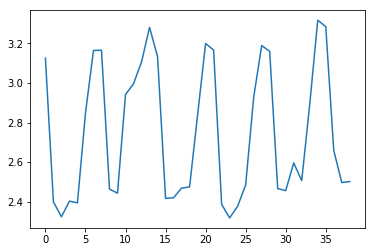

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.812634   
air_0164b9927d20bcc3_2017-04-23              1.323400   
air_0241aa3964b7f861_2017-04-23              2.379329   
air_0328696196e46f18_2017-04-23              2.167438   
air_034a3d5b40d5b1b1_2017-04-23              3.518547   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.126566  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.756169  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.797652  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.735870  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.735378

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l5_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')